In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import torchvision

import torchaudio
import torchaudio.transforms as T

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/UrbanSound8K/slices_2d/slice_2d_filenames.csv')
df.head()

,Unnamed: 0,file_path,classid
0,0,../data/UrbanSound8K/slices_2d/fold1/46654-6-0...,6
1,1,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0
2,2,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0
3,3,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0
4,4,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0


In [3]:
len(df['classid'].unique())

10

In [4]:
df['fold'] = [int(text[-2][-1]) for text in df['file_path'].str.split('/')]

In [5]:
df.head()

,Unnamed: 0,file_path,classid,fold
0,0,../data/UrbanSound8K/slices_2d/fold1/46654-6-0...,6,1
1,1,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0,1
2,2,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0,1
3,3,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0,1
4,4,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0,1


In [6]:
class UrbanSoundDataset_time_stretch(Dataset):
    def __init__(self, df, rate):
        self.df = df
        self.rate = rate
        self.stretch = T.TimeStretch(n_freq=32)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = np.load(row['file_path'])
        x = torch.tensor(x).float()
        x = self.stretch(x, self.rate)
        y = torch.tensor(row['classid'])
        return x, y
        

In [7]:
df_train = df[df['fold'] < 8]

In [8]:
df_val = df.drop(df_train.index)

In [9]:
df_train.shape[0], df_val.shape[0], df.shape[0]

(36175, 8100, 44275)

In [10]:
ds_train = UrbanSoundDataset_time_stretch(df_train, rate=2)
ds_val = UrbanSoundDataset_time_stretch(df_val, rate=2)
dl_train = DataLoader(ds_train, batch_size=1000, shuffle=True)
dl_val = DataLoader(ds_train, batch_size=500, shuffle=False)

In [11]:
next(iter(ds_train))[0].shape

torch.Size([32, 8, 2])

In [12]:
class CNN_time_2(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, padding=1)
        
        self.linear1 = nn.Linear(256, 100)
        self.linear2 = nn.Linear(100, 10)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.flatten = nn.Flatten()
        
        self.dropout = nn.Dropout2d(p=0.2)
        
        
    def forward(self, x):
        # helpful to do this along the way sometimes!
        #print(x.shape)
        
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.tanh(x)
        x = self.pool(x)

        x = self.dropout(x)
        x = self.flatten(x)
        
        # unroll x for FC layer
        x = self.linear1(self.flatten(x))
        x = self.relu(x)
        x = self.linear2(x)
        
        return x

In [13]:
model = CNN_time_2()
from torchsummary import summary
summary(model, input_size = (32, 8, 2), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 9, 3]           8,256
              Tanh-2             [-1, 64, 9, 3]               0
         MaxPool2d-3             [-1, 64, 4, 1]               0
            Conv2d-4            [-1, 128, 5, 2]          32,896
              Tanh-5            [-1, 128, 5, 2]               0
         MaxPool2d-6            [-1, 128, 2, 1]               0
         Dropout2d-7            [-1, 128, 2, 1]               0
           Flatten-8                  [-1, 256]               0
           Flatten-9                  [-1, 256]               0
           Linear-10                  [-1, 100]          25,700
             ReLU-11                  [-1, 100]               0
           Linear-12                   [-1, 10]           1,010
Total params: 67,862
Trainable params: 67,862
Non-trainable params: 0
---------------------------------

In [14]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_acc = []
    
    softmax = nn.Softmax(dim=1)
    
    for x, y in dataloader:
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        acc = 1 - (torch.count_nonzero(y - y_pred).item() / y.shape[0])
        
        total_acc.append(acc)
        
    return round(np.mean(total_acc),2)

In [15]:
from tqdm.notebook import tqdm
def train_epoch(num_epochs, model, dl_train, dl_val, optimizer, lossFun, ds_train, ds_val):
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in tqdm(range(num_epochs)):
        print('Epoch: ', epoch)

        train_loss = one_pass(model, dl_train, optimizer, lossFun)
        train_losses.append(train_loss)
        print('Train loss: ', train_loss)

        valid_loss = one_pass(model, dl_val, optimizer, lossFun, backwards=False)
        valid_losses.append(valid_loss)
        print('Valid loss: ', valid_loss)

        train_acc = one_pass_acc(model, dl_train, len(ds_train))
        train_accs.append(train_acc)
        valid_acc = one_pass_acc(model, dl_val, len(ds_val))
        valid_accs.append(valid_acc)
        print('Train Acc: ', train_acc)
        print('Valid Acc: ', valid_acc)
    
    return train_losses, valid_losses, train_accs, valid_accs
    

In [16]:
import seaborn as sns

In [17]:
def plot_results(train_loss, val_loss, train_acc, val_acc):
    sns.set_theme()
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Losses')
    axes[0].legend()
    
    axes[1].plot(train_acc, label='train')
    axes[1].plot(val_acc, label='validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.show()

In [18]:
ds_train = UrbanSoundDataset_time_stretch(df_train, rate=2)
ds_val = UrbanSoundDataset_time_stretch(df_val, rate=2)
dl_train = DataLoader(ds_train, batch_size=100, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=100, shuffle=False)

In [19]:
num_epoch = 10
model = CNN_time_2()
dl_train = dl_train
dl_val = dl_val
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
lossFun = nn.CrossEntropyLoss()
ds_train = ds_train
ds_val = ds_val

train_losses, valid_losses, train_accs, valid_accs = train_epoch(num_epoch, model, dl_train, dl_val, optimizer, lossFun, ds_train, ds_val)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  1.7583496461915706


  0%|          | 0/81 [00:00<?, ?it/s]

Valid loss:  1.6199871787318476
Train Acc:  0.45
Valid Acc:  0.38
Epoch:  1


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  1.3950938246526772


  0%|          | 0/81 [00:00<?, ?it/s]

Valid loss:  1.563652499958321
Train Acc:  0.54
Valid Acc:  0.44
Epoch:  2


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  1.211878575014146


  0%|          | 0/81 [00:00<?, ?it/s]

Valid loss:  1.687024759657589
Train Acc:  0.61
Valid Acc:  0.45
Epoch:  3


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  1.0869892183588354


  0%|          | 0/81 [00:00<?, ?it/s]

Valid loss:  1.7155872252252367
Train Acc:  0.66
Valid Acc:  0.5
Epoch:  4


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.9996525720996752


  0%|          | 0/81 [00:00<?, ?it/s]

Valid loss:  1.7826287672843462
Train Acc:  0.68
Valid Acc:  0.49
Epoch:  5


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.9292395350353494


  0%|          | 0/81 [00:00<?, ?it/s]

Valid loss:  1.827487763799267
Train Acc:  0.7
Valid Acc:  0.45
Epoch:  6


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.8715902504341378


  0%|          | 0/81 [00:00<?, ?it/s]

Valid loss:  1.8163299957911174
Train Acc:  0.72
Valid Acc:  0.45
Epoch:  7


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.8138992348428589


  0%|          | 0/81 [00:00<?, ?it/s]

Valid loss:  1.8894779277436526
Train Acc:  0.75
Valid Acc:  0.44
Epoch:  8


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.772974194742698


  0%|          | 0/81 [00:00<?, ?it/s]

Valid loss:  1.8982369185965737
Train Acc:  0.76
Valid Acc:  0.46
Epoch:  9


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.7333948073795488


  0%|          | 0/81 [00:00<?, ?it/s]

Valid loss:  2.067497491836548
Train Acc:  0.77
Valid Acc:  0.44


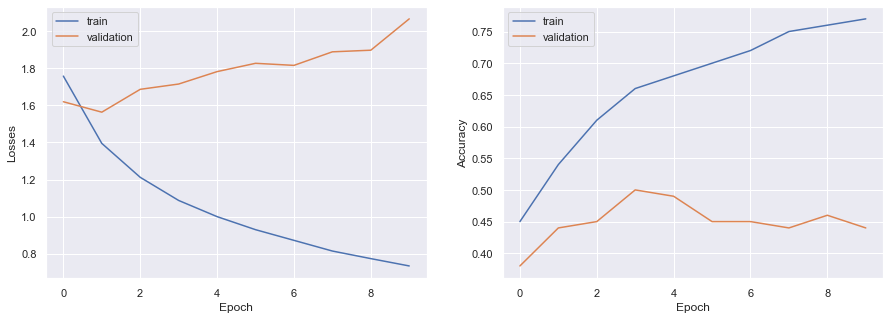

In [20]:
plot_results(train_losses, valid_losses, train_accs, valid_accs)

In [27]:
def plot_results(train_loss, val_loss, train_acc, val_acc, save=False):
    sns.set_theme()
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Losses')
    axes[0].legend()
    
    axes[1].plot(train_acc, label='train')
    axes[1].plot(val_acc, label='validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    if save:
        plt.savefig('3d_double_speed', dpi=150)

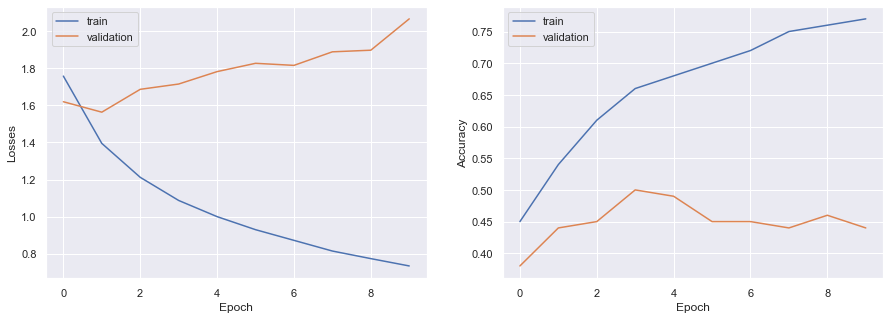

In [28]:
plot_results(train_losses, valid_losses, train_accs, valid_accs, save=True)